# Isochrone Map of a 10-minute walkshed of the L Line Chinatown Station

For my individual assignment, I am going to develop a walkshed map of the Chinatown Station. This will help my group understand which census tracts to consider when measuring the percentage change in immigrant households around the station after the rail line was installed. 

### Importing libraries and data

I begin by importing all the relevant libraries to develop my isochrone map. 

In [1]:
# for spatial data
import geopandas as gpd

# for plotting
import matplotlib.pyplot as plt

# for network analysis
import networkx as nx

# for street network analysis
import osmnx as ox

# for basemaps
import contextily as ctx

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


I now have to set the parameters of the area and action I want to map. 

In [2]:
# configure the place, network type, trip times, and travel speed
address = 'Chinatown Station, North Spring Street, Naud Junction, Chinatown, Los Angeles, Los Angeles County, California, 90012, United States'
network_type = 'walk'
trip_times = [10] 
meters_per_minute = 80 # travel distance per minute

### Introducing the street network

Now I bring in our street network.

In [3]:
%%time
# %%time is a magic command to see how long it takes this cell to run 

# download the street network
G = ox.graph_from_address(address, network_type=network_type, dist = 2000)

CPU times: user 6.41 s, sys: 178 ms, total: 6.58 s
Wall time: 6.61 s


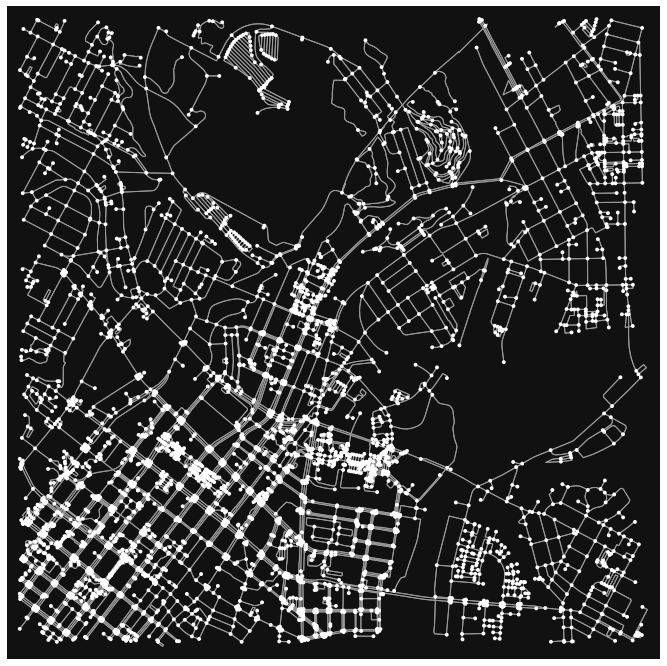

In [4]:
fig, ax = ox.plot_graph(G,figsize=(12,12))

There's the Chinatown Station area! Let's project this to Web Mercator so we can convert this into a dataframe.

In [5]:
G = ox.project_graph(G, to_crs='epsg:3857')

In [6]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [7]:
gdf_nodes.head()

y             x          highway  street_count  \
osmid                                                                   
14798411    4.039081e+06 -1.315971e+07  traffic_signals             5   
6789908773  4.039080e+06 -1.315962e+07              NaN             3   
6731341960  4.039242e+06 -1.315981e+07              NaN             3   
6789908769  4.039133e+06 -1.315970e+07              NaN             3   
5575334426  4.039055e+06 -1.315978e+07              NaN             3   

                   lon        lat                           geometry  
osmid                                                                 
14798411   -118.215695  34.076514  POINT (-13159710.938 4039080.566)  
6789908773 -118.214834  34.076509  POINT (-13159615.081 4039079.894)  
6731341960 -118.216586  34.077716  POINT (-13159810.135 4039242.206)  
6789908769 -118.215563  34.076900  POINT (-13159696.288 4039132.524)  
5575334426 -118.216303  34.076322  POINT (-13159778.698 4039054.843)

### Plotting the station area

<AxesSubplot:>

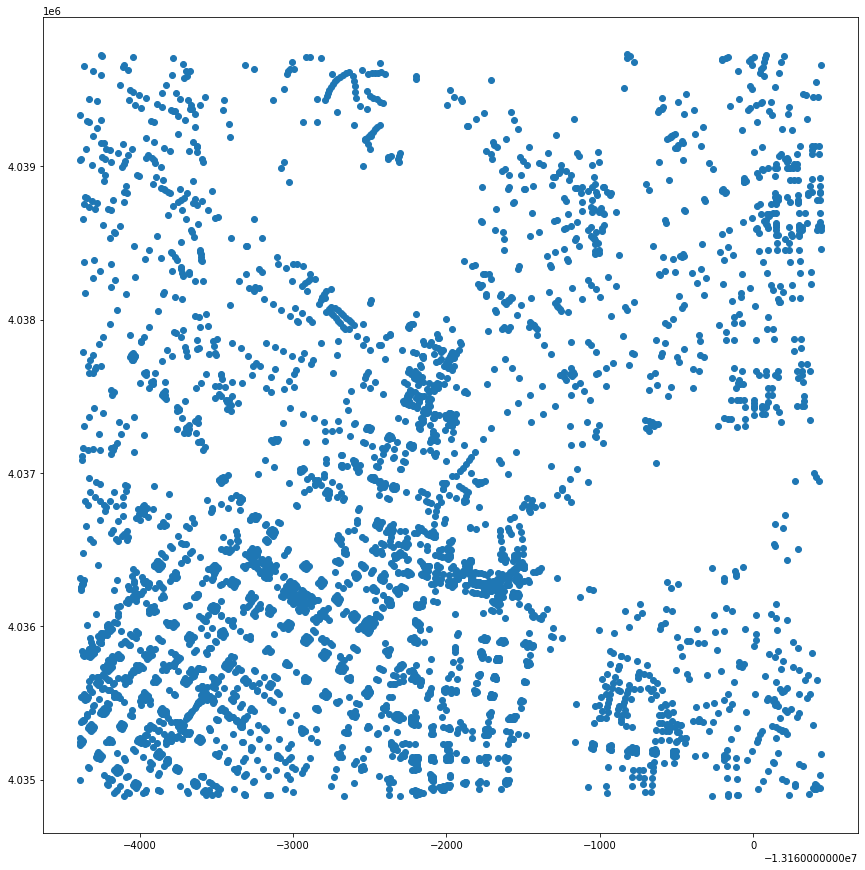

In [8]:
gdf_nodes.plot(figsize=(15,15))

These are all the nodes, or street intersections, that make up our station area! Let's pull in our edges, or streets.

In [9]:
gdf_edges.head()

osmid             name      highway  \
u        v          key                                                         
14798411 6789908773 0                   4386491        Avenue 26  residential   
         6731341960 0                 185887318        Avenue 26      primary   
         6789908769 0                 185887377  Pasadena Avenue    secondary   
         5575334426 0                 390797519  Pasadena Avenue    secondary   
         7874238662 0    [398404000, 398403999]      Daly Street      primary   

                         oneway   length  \
u        v          key                    
14798411 6789908773 0     False   79.498   
         6731341960 0     False  159.302   
         6789908769 0     False   44.665   
         5575334426 0     False   60.407   
         7874238662 0     False   55.836   

                                                                  geometry  \
u        v          key                                                      
14798411 6789908773 0    LINESTRING (-13159710.938 4039080.566, -131596...   
         6731341960 0    LINESTRING (-13159710.938 4039080.566, -131597...   
         6789908769 0    LINESTRING (-13159710.938 4039080.566, -131597...   
         5575334426 0    LINESTRING (-13159710.938 4039080.566, -131597...   
         7874238662 0    LINESTRING (-13159710.938 4039080.566, -131597...   

                          lanes maxspeed service access bridge tunnel width  
u        v          key                                                      
14798411 6789908773 0       NaN      NaN     NaN    NaN    NaN    NaN   NaN  
         6731341960 0         4      NaN     NaN    NaN    NaN    NaN   NaN  
         6789908769 0         3   35 mph     NaN    NaN    NaN    NaN   NaN  
         5575334426 0         5   35 mph     NaN    NaN    NaN    NaN   NaN  
         7874238662 0    [4, 5]      NaN     NaN    NaN    NaN    NaN   NaN

<AxesSubplot:>

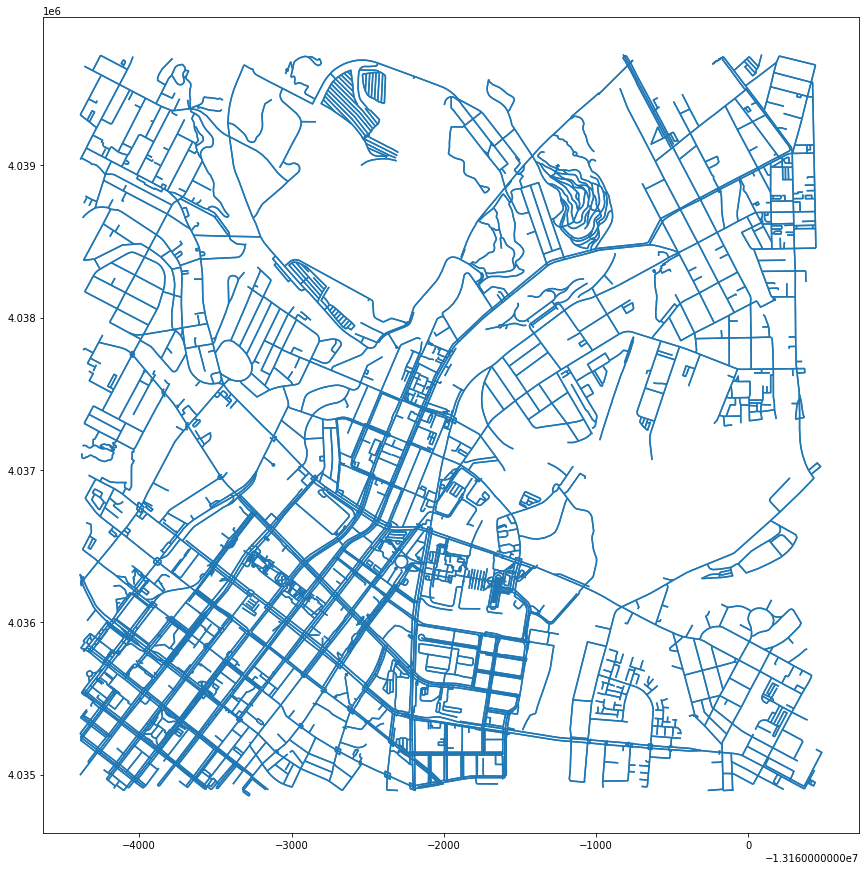

In [10]:
gdf_edges.plot(figsize=(15,15))

Now let's layer our nodes with our edges. 

KeyError: 'Chinatown Station, North Spring Street, Naud Junction, Chinatown, Los Angeles, Los Angeles County, California, 90012, United States'

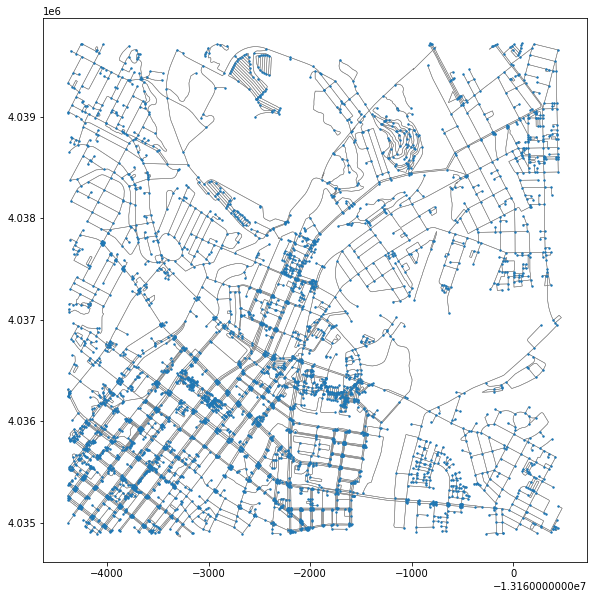

In [11]:
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add the edges to ax
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               edgecolor='gray', 
               zorder=10)

# add all nodes to ax
gdf_nodes.plot(ax=ax, 
               markersize=2, 
               zorder=20)

# add the center node in red also to ax
gdf_nodes.loc[address].plot(ax=ax,
                                  color='r', 
                                  zorder=30)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,zoom=14)

The map still populated but we're missing a dot showing our station as our center node. I'm going to lean on what we learned in class to find the centroid and hopefully that'll be the station. 

In [12]:
minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
print(minx)
print(miny)
print(maxx)
print(maxy)

-13164388.63843997
4034895.105361979
-13159557.071976917
4039728.027453392


Now we calculate the difference, split it in half, and add it to the min in order to land at the center.

In [13]:
centroid_x = (maxx-minx)/2 + minx
centroid_y = (maxy-miny)/2 + miny
print(centroid_x)
print(centroid_y)

-13161972.855208443
4037311.566407685


This is our lat and long for our centroid. We use this to find the nearest node to these coordinates. This will be the node for our center point.

In [14]:
center_node = ox.distance.nearest_nodes(G,Y=centroid_y,X=centroid_x)

In [15]:
print('The id for the nearest node is ' + str(center_node))

The id for the nearest node is 8290553666


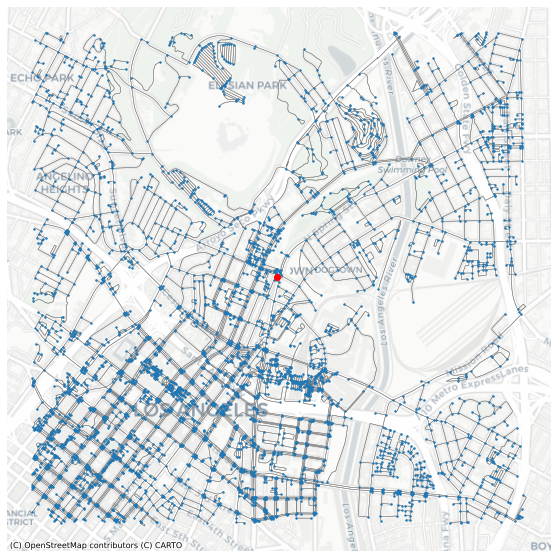

In [16]:
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add the edges to ax
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               edgecolor='gray', 
               zorder=10)

# add all nodes to ax
gdf_nodes.plot(ax=ax, 
               markersize=2, 
               zorder=20)

# add the center node in red also to ax
gdf_nodes.loc[[8290553666]].plot(ax=ax,
                                  color='r', 
                                  zorder=30)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,zoom=14)

After referencing OpenStreet Maps, I can see that our center point is just shy of landing on our station. I will move forward now for the sake of the exercise but I would like to know if there's a way to use the address of the Chinatown Station we started with to find the nearest node to it.

Let's take a look at our columns again. 

### Calculating walk time and identifying our walkshed nodes

In [17]:
gdf_edges.sample(5)

osmid             name  \
u          v          key                                                       
9071181045 123311713  0                             13397682  Ducommun Street   
6471204766 5999772836 0                            976799033              NaN   
1362903942 6208583538 0    [663272177, 121832044, 663272183]              NaN   
604238319  7170775703 0                            161716760  East 1st Street   
25936324   2094664133 0                              4927870              NaN   

                                highway  oneway   length  \
u          v          key                                  
9071181045 123311713  0    unclassified   False    6.999   
6471204766 5999772836 0         footway   False  144.919   
1362903942 6208583538 0         footway   False   35.752   
604238319  7170775703 0       secondary   False   51.809   
25936324   2094664133 0    unclassified   False   15.432   

                                                                    geometry  \
u          v          key                                                      
9071181045 123311713  0    LINESTRING (-13161778.386 4035830.484, -131617...   
6471204766 5999772836 0    LINESTRING (-13162795.790 4035794.785, -131629...   
1362903942 6208583538 0    LINESTRING (-13161650.257 4036260.009, -131616...   
604238319  7170775703 0    LINESTRING (-13159730.074 4034958.491, -131597...   
25936324   2094664133 0    LINESTRING (-13161295.983 4038642.804, -131612...   

                          lanes maxspeed service access bridge tunnel width  
u          v          key                                                    
9071181045 123311713  0     NaN   25 mph     NaN    NaN    NaN    NaN   NaN  
6471204766 5999772836 0     NaN      NaN     NaN    NaN    NaN    NaN   NaN  
1362903942 6208583538 0     NaN      NaN     NaN    NaN    NaN    yes   NaN  
604238319  7170775703 0       2      NaN     NaN    NaN    NaN    NaN   NaN  
25936324   2094664133 0     NaN      NaN     NaN    NaN    NaN    NaN   NaN

We use length to create our walkshed layer. We first need a new column that has the time it takes to walk to the station based on our 80 meters per minute assumption. We create that new column below.

In [18]:
gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

In [45]:
gdf_edges.sample(5)

osmid                   name   highway  oneway  \
u          v          key                                                       
605023200  605023198  0     13343354                    NaN   service   False   
4972301243 4972301239 0    507791365                    NaN   footway   False   
6726508712 6726508713 0    715752193                    NaN   service   False   
8460490478 123331084  0    791976828           Scott Avenue  tertiary   False   
123185011  123426792  0    139639790  Cesar E Chavez Avenue   primary   False   

                           length  \
u          v          key           
605023200  605023198  0    25.305   
4972301243 4972301239 0    30.342   
6726508712 6726508713 0    18.953   
8460490478 123331084  0    82.677   
123185011  123426792  0    43.093   

                                                                    geometry  \
u          v          key                                                      
605023200  605023198  0    LINESTRING (-13160885.826 4035426.005, -131608...   
4972301243 4972301239 0    LINESTRING (-13162062.373 4036310.032, -131620...   
6726508712 6726508713 0    LINESTRING (-13163635.696 4037340.785, -131636...   
8460490478 123331084  0    LINESTRING (-13163672.932 4039370.827, -131636...   
123185011  123426792  0    LINESTRING (-13160411.928 4035901.882, -131603...   

                          lanes maxspeed service access bridge tunnel width  \
u          v          key                                                     
605023200  605023198  0     NaN      NaN     NaN    NaN    NaN    NaN   NaN   
4972301243 4972301239 0     NaN      NaN     NaN    NaN    NaN    NaN   NaN   
6726508712 6726508713 0     NaN      NaN     NaN    NaN    NaN    NaN   NaN   
8460490478 123331084  0       2      NaN     NaN    NaN    NaN    NaN   NaN   
123185011  123426792  0       4      NaN     NaN    NaN    NaN    NaN   NaN   

                           walk_time  
u          v          key             
605023200  605023198  0     0.316312  
4972301243 4972301239 0     0.379275  
6726508712 6726508713 0     0.236913  
8460490478 123331084  0     1.033463  
123185011  123426792  0     0.538663

In the far right we have that walk time column! Now I shift to picking the colors of the isochrone layer. I am going to use the get_colors command to be given a suggested color.  

### Coloring my nodes

In [20]:
# assign a color hex code for each trip time isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                cmap='plasma', 
                                start=0, 
                                return_hex=True)
print(trip_times)
print(iso_colors)

[10]
['#0d0887']


Now I need to marry my walkshed nodes to their color. 

In [21]:
time_color = list(zip(trip_times, iso_colors))
time_color

[(10, '#0d0887')]

I now use the ego_graph command to color each node that is within my walkshed

In [23]:
for time, color in list(time_color):

    # for each trip time, create an egograph of nodes that fall within that distance
    subgraph = nx.ego_graph(G, center_node, radius=time)

    print('There are ' + str(len(subgraph.nodes())) + ' nodes within ' + str(time) + ' minutes ')
    
    # for each of those nodes, update the gdf_nodes dataframe and assign it with its associated distance color
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = str(time) + ' mins'
        gdf_nodes.loc[node,'color'] = color

There are 120 nodes within 10 minutes 


In [24]:
gdf_nodes.sample(50)

y             x          highway  street_count  \
osmid                                                                   
5707482159  4.038984e+06 -1.315994e+07              NaN             4   
9035676093  4.036012e+06 -1.316420e+07         crossing             1   
9413291932  4.035125e+06 -1.316210e+07              NaN             3   
1884280942  4.035231e+06 -1.316160e+07              NaN             3   
26462442    4.037175e+06 -1.316223e+07  traffic_signals             4   
8415721499  4.036170e+06 -1.316301e+07              NaN             1   
21420505    4.036631e+06 -1.316236e+07  traffic_signals             4   
6699521855  4.035495e+06 -1.316393e+07         crossing             4   
8290762647  4.037030e+06 -1.316259e+07              NaN             1   
1967647089  4.038380e+06 -1.316189e+07              NaN             3   
5689452770  4.035979e+06 -1.316418e+07         crossing             4   
269444244   4.037804e+06 -1.316250e+07              NaN             3   
9033521022  4.037778e+06 -1.316405e+07         crossing             1   
8385761648  4.035113e+06 -1.316305e+07              NaN             4   
3665206540  4.035167e+06 -1.316426e+07         crossing             4   
8881484944  4.036467e+06 -1.316228e+07              NaN             4   
6883792554  4.037611e+06 -1.316220e+07              NaN             4   
6731343126  4.037918e+06 -1.316018e+07              NaN             1   
9032969263  4.036701e+06 -1.316324e+07         crossing             3   
123331082   4.039371e+06 -1.316366e+07              NaN             4   
7232058463  4.034939e+06 -1.316164e+07              NaN             1   
6875033986  4.038079e+06 -1.316127e+07              NaN             4   
8881631508  4.035908e+06 -1.316221e+07              NaN             4   
4409173284  4.036269e+06 -1.316199e+07              NaN             3   
8881484973  4.036358e+06 -1.316249e+07              NaN             4   
5680974439  4.035154e+06 -1.316386e+07              NaN             4   
1362903942  4.036260e+06 -1.316165e+07              NaN             4   
6735025111  4.035084e+06 -1.316434e+07              NaN             4   
2119026752  4.037109e+06 -1.316438e+07              NaN             3   
4632585776  4.035549e+06 -1.316414e+07              NaN             1   
29312309    4.038280e+06 -1.316095e+07              NaN             3   
7191339462  4.036010e+06 -1.316434e+07              NaN             1   
8873772543  4.036203e+06 -1.316302e+07              NaN             4   
268653463   4.037404e+06 -1.316340e+07   turning_circle             1   
8881631570  4.035424e+06 -1.316243e+07              NaN             1   
3663757075  4.038451e+06 -1.316101e+07              NaN             4   
3898603031  4.035298e+06 -1.316384e+07              NaN             3   
6726683440  4.037952e+06 -1.316360e+07              NaN             3   
3898644878  4.036360e+06 -1.316314e+07              NaN             4   
1204008737  4.037750e+06 -1.316215e+07              NaN             3   
3297564574  4.035653e+06 -1.316351e+07         crossing             4   
5814039157  4.036105e+06 -1.316392e+07              NaN             4   
9456207658  4.035269e+06 -1.316158e+07              NaN             1   
67619278    4.035848e+06 -1.316238e+07  traffic_signals             3   
1738812372  4.036936e+06 -1.316201e+07         crossing             3   
7191339459  4.035934e+06 -1.316427e+07              NaN             1   
122954614   4.034904e+06 -1.316017e+07              NaN             3   
4409000012  4.036219e+06 -1.316182e+07              NaN             1   
9051625187  4.035455e+06 -1.316284e+07         crossing             1   
464745354   4.037550e+06 -1.315988e+07              NaN             1   

                   lon        lat                           geometry     time  \
osmid                                                                           
5707482159 -118.217752  34.075795  POINT (-13159939.978 4038984.

Okay, I ran the sample(5) then sample(10) and still didn't see any, but after running sample(50) I see some nodes that are colored. 

I now need to assign a color the nodes that are not in our walkshed. I liked the grey we used in class so I'm going to adopt that for the nodes outside of our walkshed.

In [25]:
gdf_nodes['color'].fillna('#cccccc', inplace=True)

Now when I run a sample I should see a color assigned to every node. 

In [26]:
gdf_nodes.sample(5)

y             x highway  street_count         lon  \
osmid                                                                      
5168803689  4.039582e+06 -1.316269e+07     NaN             3 -118.242478   
8406684234  4.036567e+06 -1.316253e+07     NaN             3 -118.241011   
6726508703  4.037204e+06 -1.316360e+07     NaN             3 -118.250606   
8873643370  4.036087e+06 -1.316316e+07     NaN             4 -118.246696   
5547192133  4.036855e+06 -1.316244e+07     NaN             1 -118.240197   

                  lat                           geometry time    color  
osmid                                                                   
5168803689  34.080244  POINT (-13162692.419 4039581.998)  NaN  #cccccc  
8406684234  34.057812  POINT (-13162529.147 4036567.369)  NaN  #cccccc  
6726508703  34.062552  POINT (-13163597.201 4037204.354)  NaN  #cccccc  
8873643370  34.054238  POINT (-13163161.942 4036087.218)  NaN  #cccccc  
5547192133  34.059955  POINT (-13162438.510 4036855.402)  NaN  #cccccc

Okay, all good! Now let's run a map of our nodes, this time with their respective colors.

<AxesSubplot:>

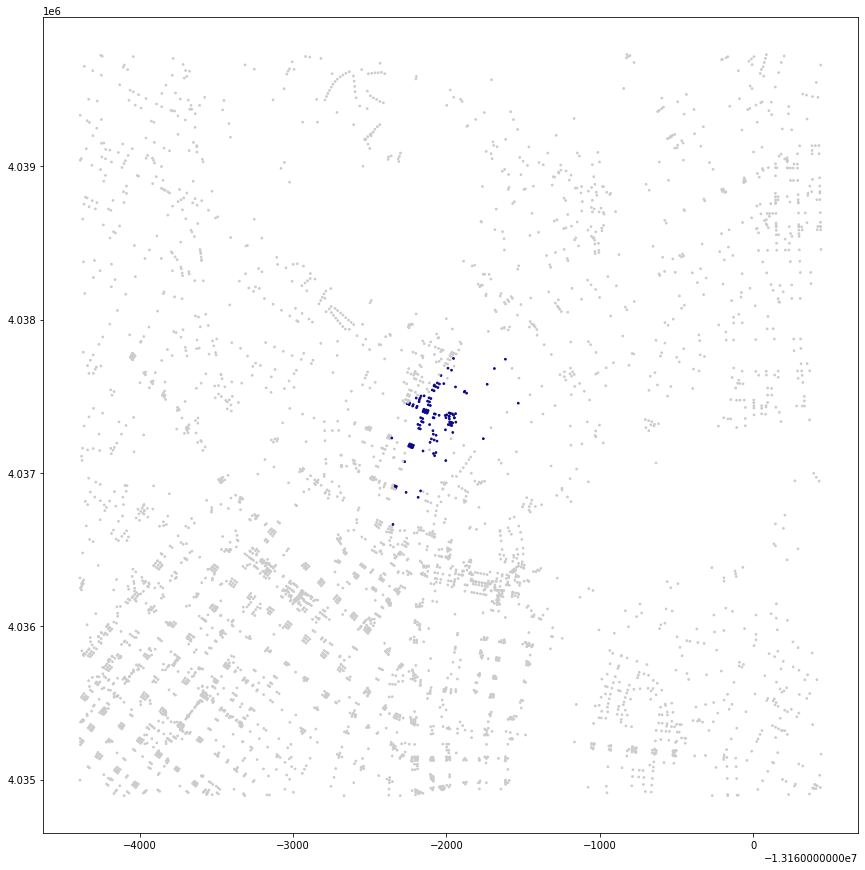

In [27]:
gdf_nodes.plot(figsize=(15,15),
               color=gdf_nodes['color'],
               markersize=3)

Our walkshed looks very small from this perspective. I'm going to zoom in a little more.

<AxesSubplot:>

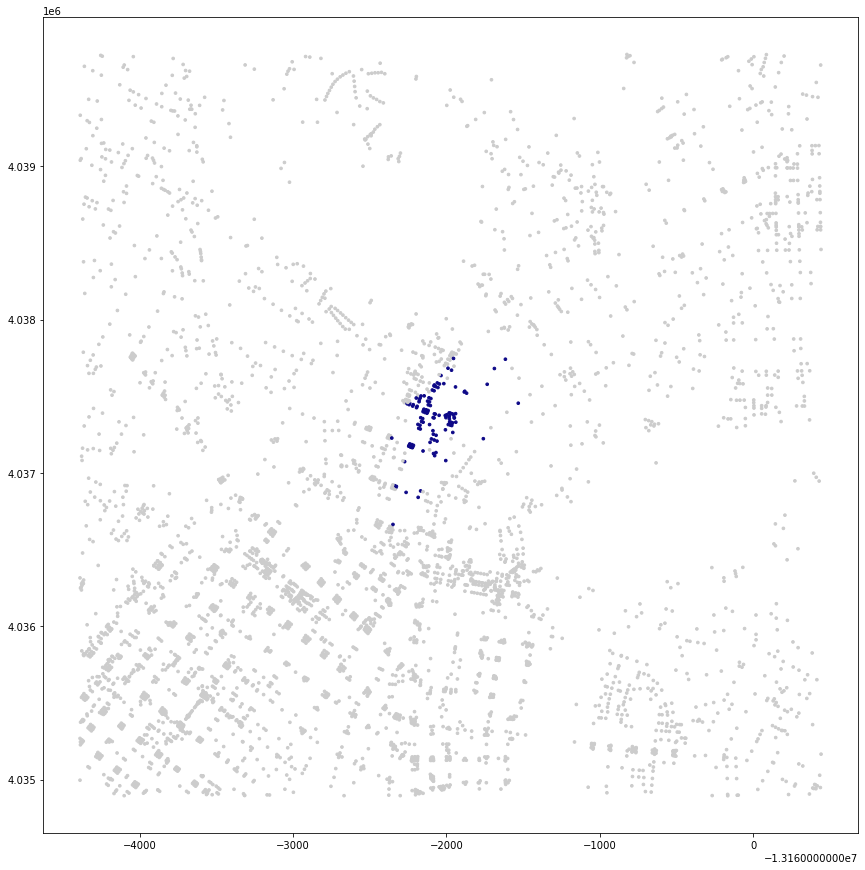

In [28]:
gdf_nodes.plot(figsize=(15,15),
               color=gdf_nodes['color'],
               markersize=7)

Now I re-introduce our edges. 

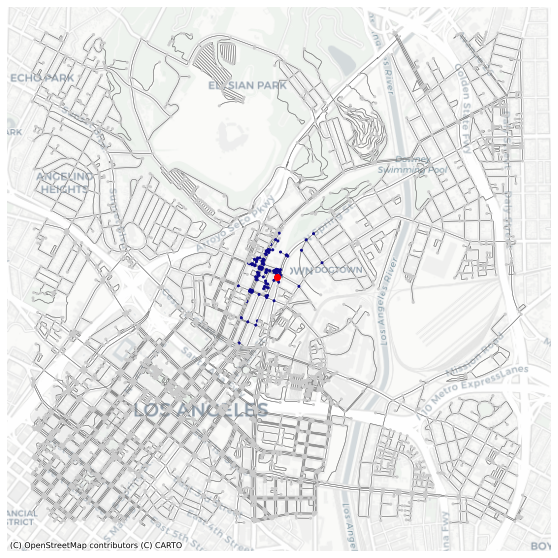

In [29]:
# a "full" map
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add the edges to ax
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               edgecolor='gray', 
               zorder=10)

# add all nodes to ax
gdf_nodes.plot(ax=ax,
               color=gdf_nodes['color'],
               markersize=4, 
               zorder=20)

# add the center node in red also to ax
gdf_nodes.loc[[center_node]].plot(ax=ax,
                                  color='r', 
                                  zorder=30)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,zoom=14)

### Turning nodes into polygons

Finally, I connect the nodes that make up our walkshed into a polygon to complete our ischrone. First, I need to identify the nodes in our walkshed. 

In [30]:
gdf_nodes[gdf_nodes['time']=='10 mins']

y             x          highway  street_count  \
osmid                                                                   
17677673    4.037351e+06 -1.316198e+07              NaN             3   
67619377    4.037281e+06 -1.316201e+07              NaN             3   
268373135   4.037331e+06 -1.316194e+07  traffic_signals             4   
4015456423  4.037360e+06 -1.316200e+07              NaN             3   
17677675    4.037402e+06 -1.316214e+07  traffic_signals             4   
...                  ...           ...              ...           ...   
8290553672  4.037330e+06 -1.316197e+07              NaN             3   
8290553673  4.037324e+06 -1.316197e+07         elevator             1   
8409457169  4.037488e+06 -1.316217e+07              NaN             3   
8409457171  4.037477e+06 -1.316218e+07              NaN             1   
8409457170  4.037501e+06 -1.316217e+07              NaN             1   

                   lon        lat                           geometry     time  \
osmid                                                                           
17677673   -118.236082  34.063645  POINT (-13161980.397 4037351.213)  10 mins   
67619377   -118.236313  34.063122  POINT (-13162006.145 4037280.975)  10 mins   
268373135  -118.235705  34.063492  POINT (-13161938.430 4037330.613)  10 mins   
4015456423 -118.236282  34.063710  POINT (-13162002.706 4037359.961)  10 mins   
17677675   -118.237476  34.064025  POINT (-13162135.565 4037402.222)  10 mins   
...                ...        ...                                ...      ...   
8290553672 -118.235983  34.063489  POINT (-13161969.376 4037330.197)  10 mins   
8290553673 -118.235999  34.063440  POINT (-13161971.236 4037323.585)  10 mins   
8409457169 -118.237797  34.064661  POINT (-13162171.299 4037487.673)  10 mins   
8409457171 -118.237841  34.064580  POINT (-13162176.286 4037476.802)  10 mins   
8409457170 -118.237745  34.064762  POINT (-13162165.510 4037501.245)  10 mins   

              color  
osmid                
17677673    #0d0887  
67619377    #0d0887  
268373135   #0d0887  
4015456423  #0d0887  
17677675    #0d0887  
...             ...  
8290553672  #0d0887  
8290553673  #0d0887  
8409457169  #0d0887  
8409457171  #0d0887  
8409457170  #0d0887  

[120 rows x 9 columns]

Just as we had seen earlier, we have 120 nodes.Let's drop these nodes into one variable.  

In [31]:
gdf_10 = gdf_nodes[gdf_nodes['time']=='10 mins']

<AxesSubplot:>

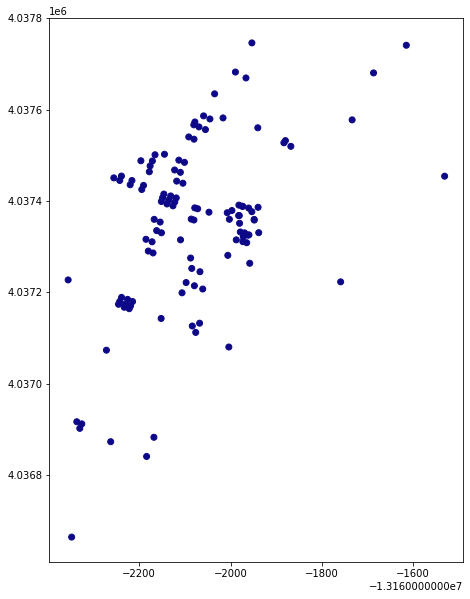

In [32]:
gdf_10.plot(figsize=(10,10),color=gdf_10.color)

There they are! Now I use the convex_hull command to essentially connect the dots. 

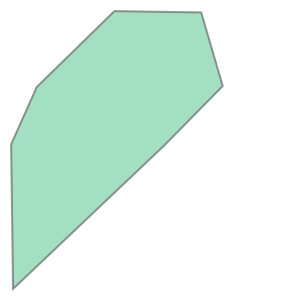

In [33]:
gdf_10.unary_union.convex_hull

In [34]:
isochrones = gdf_nodes.dissolve("time")
isochrones

geometry             y  \
time                                                                       
10 mins  MULTIPOINT (-13162355.811 4037227.171, -131623...  4.037351e+06   

                    x          highway  street_count         lon        lat  \
time                                                                          
10 mins -1.316198e+07  traffic_signals             3 -118.236082  34.063645   

           color  
time              
10 mins  #0d0887

In [35]:
isochrones = isochrones.convex_hull.reset_index()
isochrones

time                                                  0
0  10 mins  POLYGON ((-13162348.152 4036663.926, -13162355...

In [36]:
isochrones.columns=['time','geometry']
isochrones

time                                           geometry
0  10 mins  POLYGON ((-13162348.152 4036663.926, -13162355...

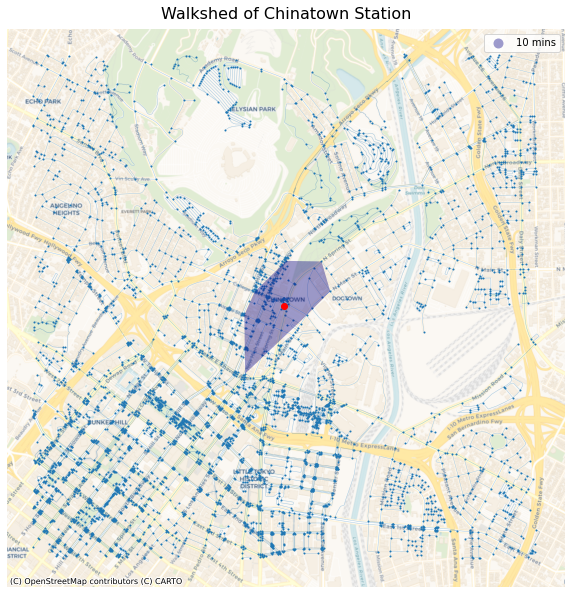

In [37]:
# set up the subplots
fig, ax = plt.subplots(figsize=(10,20))

# add the isochrones
isochrones.plot(alpha=0.4, 
                ax=ax, 
                column='time', 
                cmap='plasma', 
                legend=True,
                zorder=20)

# add the center node in red
gdf_nodes.loc[[center_node]].plot(ax=ax,color='r', zorder=30)

# add all nodes
gdf_nodes.plot(ax=ax, 
               markersize=1, 
               zorder=10)

# add the edges
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               alpha=0.2,
               zorder=10)

# hide the axis
ax.axis('off')

# give it a title
ax.set_title('Walkshed of Chinatown Station',fontsize=16,pad=10)

# add the basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Voyager)

There it is! For the midterm, I will use this map to identify which census tracts to pull in for our analysis of immigrant populations before and after the L Line was in installed. 